## Advanced Lane Finding Project

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Apply a perspective transform to rectify binary image ("birds-eye view").
4. Use color transforms, gradients, etc., to create a thresholded binary image.
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Import libraries

In [1]:
import os
import cv2
import glob
import math
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.signal import find_peaks_cwt


## 1. Camera calibration using chessboard images

In [2]:
def camera_calibration(image_tmpl, output_dir='.'):
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    h, w = 6, 9
    obj_pt = np.zeros((h*w, 3), np.float32)
    obj_pt[:, :2] = np.mgrid[0:w, 0:h].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    obj_pts = [] # 3d points in real world space
    img_pts = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(image_tmpl)

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (w, h), None)

        if ret == True:
            obj_pts.append(obj_pt)
            img_pts.append(corners)

    # Do camera calibration given object points and image points
    img = cv2.imread(images[0])
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = \
        cv2.calibrateCamera(obj_pts, img_pts, img_size, None, None)
    
    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    output_file = os.path.join(output_dir, 'dist_pickle.p')
    pickle.dump(dist_pickle, open(output_file, 'wb'))
    return (mtx, dist)
    
mtx, dist = camera_calibration('camera_cal/calibration*.jpg')

## 2. Undistort raw image

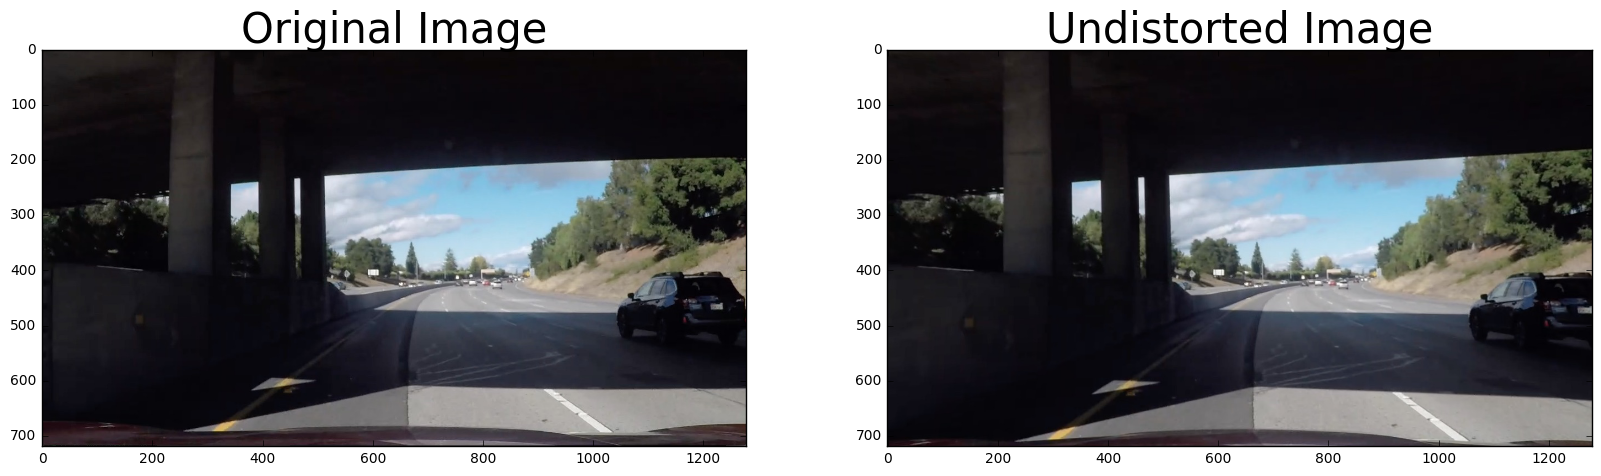

In [3]:
def load_undistort_params(input_dir='.'):
    input_file = os.path.join(input_dir, 'dist_pickle.p')
    dist_pickle = pickle.load(open(input_file, 'rb'))
    return (dist_pickle['mtx'], dist_pickle['dist'])

def undistort_image(image, mtx, dist):
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    return dst

# Test undistortion on an image
img = cv2.imread('test_images/challenge7.jpg')
mtx, dist = load_undistort_params()
dst = undistort_image(img, mtx, dist)
cv2.imwrite('test_images/challenge7_undist.jpg', dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=30)

## 3. Perspective transform

True

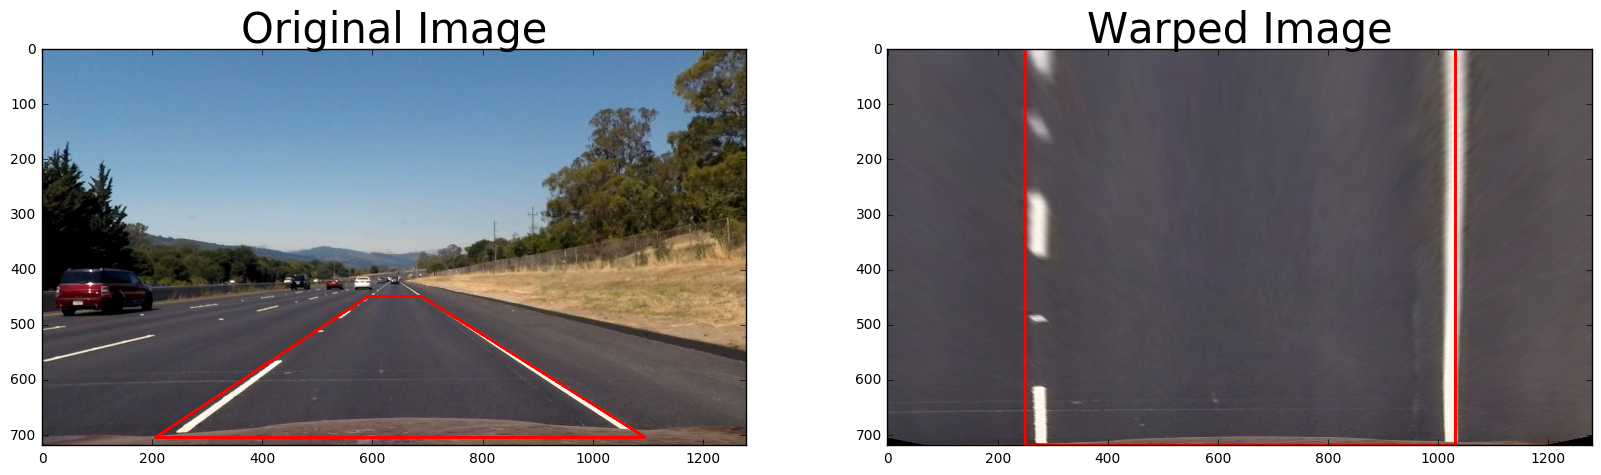

In [4]:
def perspective_transform(image, inverse=False):
    """
    Try not to see too far away where can't be identify clearly
    after transform.
    """
    src = np.float32([(592, 450), (689, 450), (205, 706), (1095, 706)])
    dst = np.float32([(250, -200), (1030, -200), (250, 720), (1030, 720)])
    
    if inverse:
        src, dst = dst, src
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, None, flags=cv2.INTER_LINEAR)
    
    return warped, M

dst = cv2.imread('test_images/straight_lines2_undist.jpg')
warped, M = perspective_transform(dst)

# Visualize perspective transform
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
pts = np.array([(592, 450), (689, 450), (1095, 706), (205, 706)])
dst_line = dst.copy()
cv2.polylines(dst_line, [pts], True, (0, 0, 255), thickness=3)
ax1.imshow(cv2.cvtColor(dst_line, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)

pts = np.array([(250, 0), (1030, 0), (1030, 720), (250, 720)])
warped_line = warped.copy()
cv2.polylines(warped_line, [pts], True, (0, 0, 255), thickness=3)
ax2.imshow(cv2.cvtColor(warped_line, cv2.COLOR_BGR2RGB))
ax2.set_title('Warped Image', fontsize=30)
cv2.imwrite('test_images/warped.jpg', cv2.cvtColor(warped_line, cv2.COLOR_BGR2RGB))

## 4. Create Threshold Binary Image (Color & Graident)

### Histogram Equalization

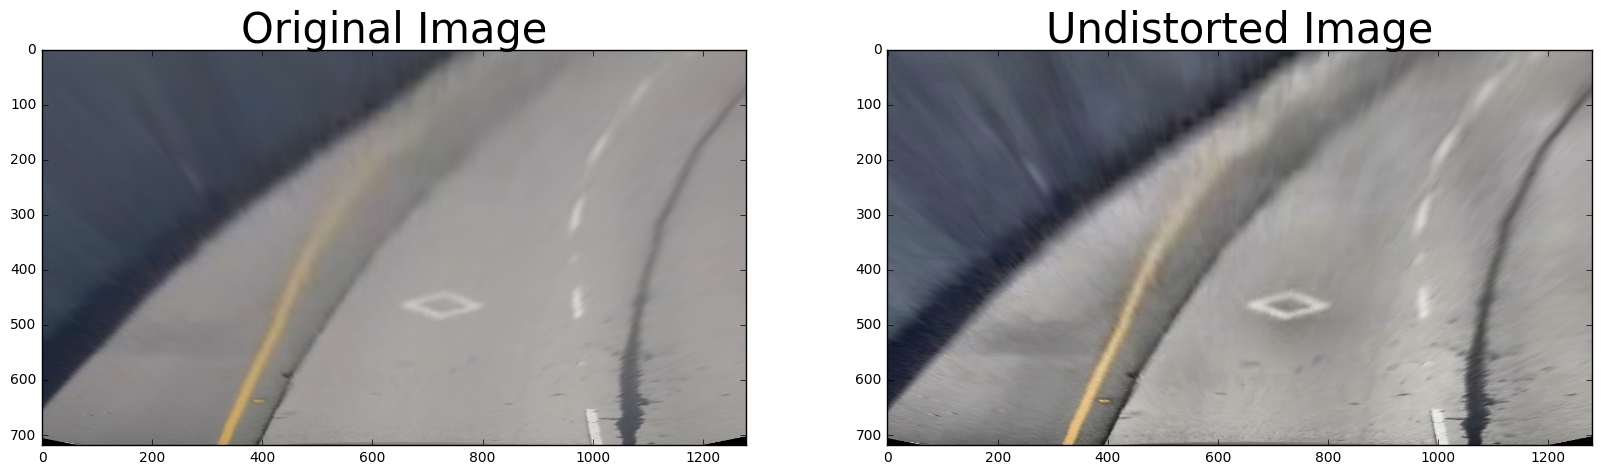

In [4]:
def histogram_equalization(image):
    """
    http://docs.opencv.org/3.2.0/d5/daf/tutorial_py_histogram_equalization.html
    """
    yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    yuv[:,:,0] = clahe.apply(yuv[:,:,0])
    image = cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR)
    
    return image

equalized = histogram_equalization(warped)

# Visualize transformed images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(equalized, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=30)

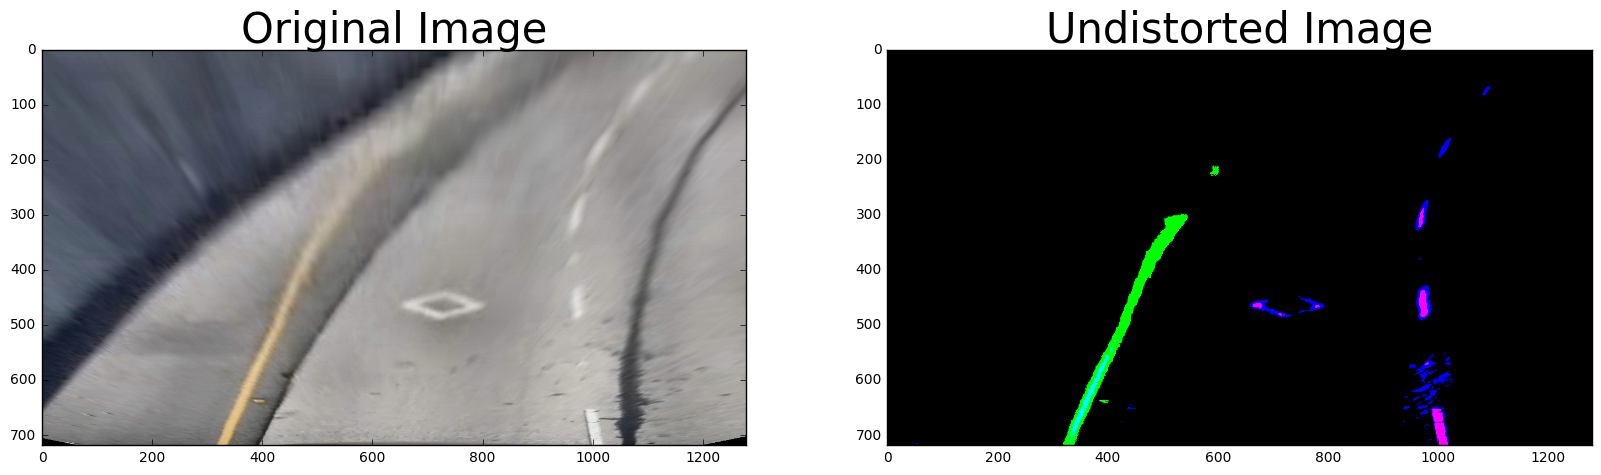

In [5]:
def create_threshold_binary_image(image, print_color=False):
    image = np.copy(image)
    
    # convert color space
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS).astype(np.float)

    # sobel x (derivative in x axis)
    s_sobelx = cv2.Sobel(hls[:,:,2], cv2.CV_64F, 1, 0)
    s_abs_sobelx = np.abs(s_sobelx)
    s_scaled_sobel = np.uint8(255*s_abs_sobelx/np.max(s_abs_sobelx))
    
    l_sobelx = cv2.Sobel(hls[:,:,1], cv2.CV_64F, 1, 0)
    l_abs_sobelx = np.abs(l_sobelx)
    l_scaled_sobel = np.uint8(255*l_abs_sobelx/np.max(l_abs_sobelx))
    
    # threshold x gradient
    sobel_min = np.array([20])
    sobel_max = np.array([100])
    s_sx_mask = cv2.inRange(s_scaled_sobel, sobel_min, sobel_max)
    l_sx_mask = cv2.inRange(l_scaled_sobel, sobel_min, sobel_max)
    sx_mask = s_sx_mask.astype('bool') & l_sx_mask.astype('bool')
    
    # threshold color channel    
    yellow_min  = np.array([ 10,  80,  70])
    yellow_max  = np.array([100, 230, 155])
    yellow_mask2 = cv2.inRange(hls, yellow_min, yellow_max)
    
    white_min  = np.array([  0, 210,   0])
    white_max  = np.array([255, 255, 255])
    white_mask2 = cv2.inRange(hls, white_min, white_max)
    
    luv = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
    yellow_min  = np.array([160,   0, 150])
    yellow_max  = np.array([255, 255, 255])
    yellow_mask = cv2.inRange(luv, yellow_min, yellow_max)
    yellow_mask = yellow_mask | yellow_mask2
    
    white_min  = np.array([200,   0,   0])
    white_max  = np.array([255, 255, 255])
    white_mask = cv2.inRange(luv, white_min, white_max)
    white_mask = white_mask | white_mask2
    if print_color:
        return np.dstack((white_mask2, yellow_mask, white_mask))

    binary = np.zeros_like(image[:,:,0])
    binary[
        #sx_mask.astype('bool') | 
        yellow_mask.astype('bool') | 
        white_mask.astype('bool')] = 1
    
    binary = cv2.erode(binary, (5, 5), iterations=1)
    return binary
    
binary_img = create_threshold_binary_image(equalized, print_color=True)
    
# Visualize transformed images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(equalized, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(binary_img, cmap='gray')
ax2.set_title('Undistorted Image', fontsize=30)

## 5. Find lane lines

/Users/chih-chuanchan/anaconda/envs/carnd-term1/lib/python3.5/site-packages/scipy/signal/_peak_finding.py:412: RuntimeWarning: divide by zero encountered in double_scalars
  snr = abs(cwt[line[0][0], line[1][0]] / noises[line[1][0]])


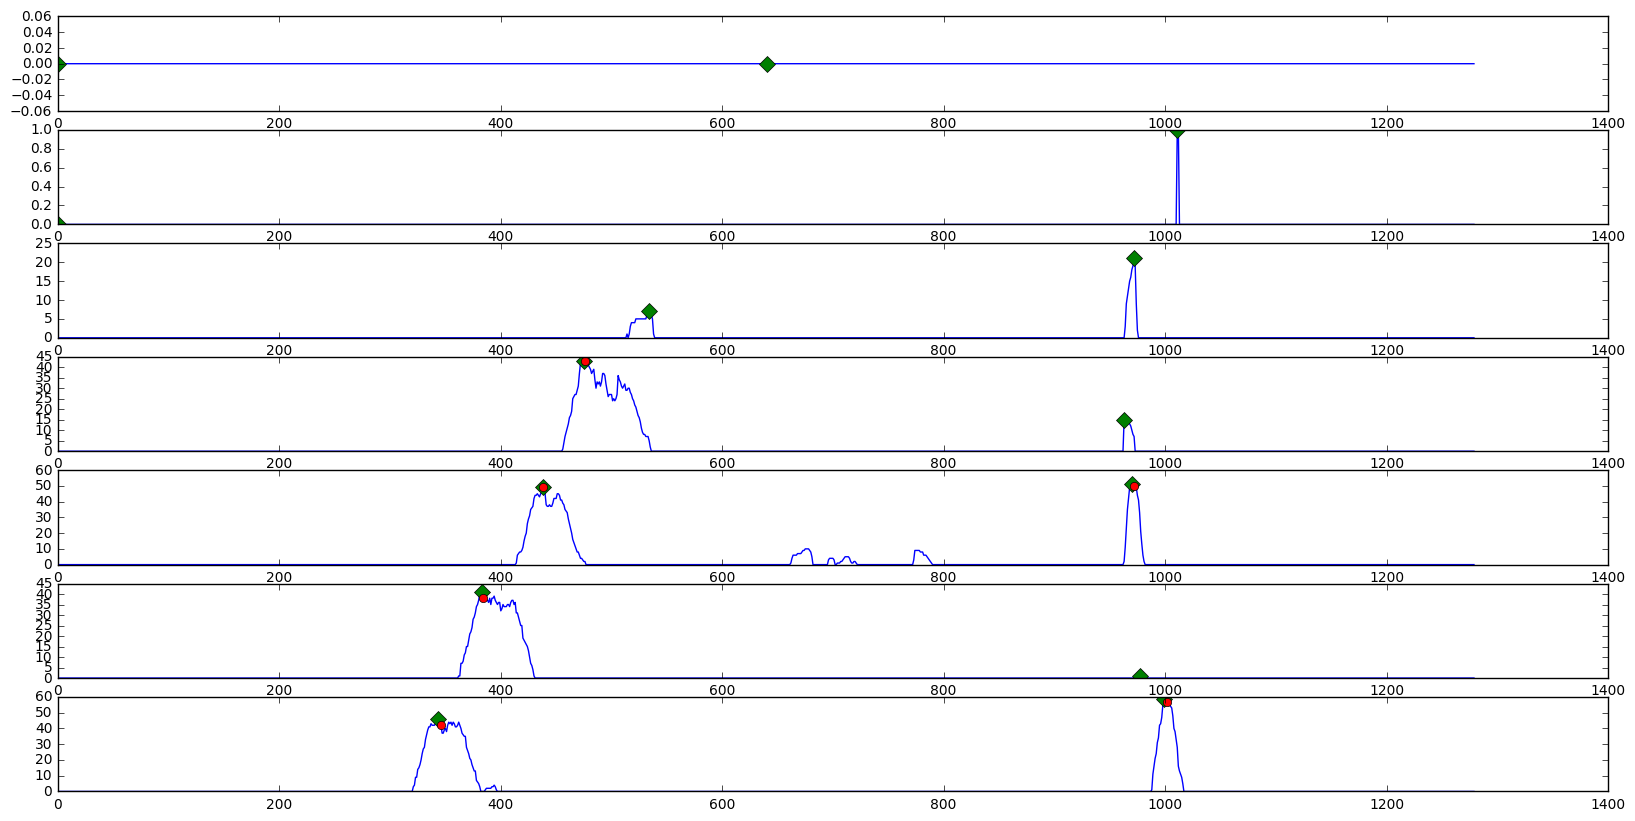

In [7]:
# Visiualize sliding window
# https://blog.ytotech.com/2015/11/01/findpeaks-in-python/

binary_img = create_threshold_binary_image(warped)

nb_win = 7
width = binary_img.shape[1]
height = binary_img.shape[0]
win_size = math.ceil(height/nb_win)

f, axes = plt.subplots(nb_win, 1, figsize=(20,10))
for i, ax in enumerate(axes):
    start = i * win_size
    end = start + win_size
    
    histogram = np.sum(binary_img[start:end,:], axis=0)
    ax.plot(histogram)
    
    # argmax
    mid = width // 2
    l_peak = np.argmax(histogram[:mid])
    r_peak = np.argmax(histogram[mid:]) + mid
    ax.plot([l_peak, r_peak], histogram[[l_peak, r_peak]], 'D', color='g', ms=8)
    
    # peak
    indexes = find_peaks_cwt(histogram, np.arange(10, 100))
    indexes = [idx for idx in indexes if histogram[idx] > 20]
    ax.plot(indexes, histogram[indexes], 'o', color='red')
    

Window (0)
Window (1)
Window (2)
Window (3)
Left lane not found. margin: 140
Window (4)
Left lane not found. margin: 180
Window (5)
Left lane not found. margin: 220
Window (6)
Left lane not found. margin: 260


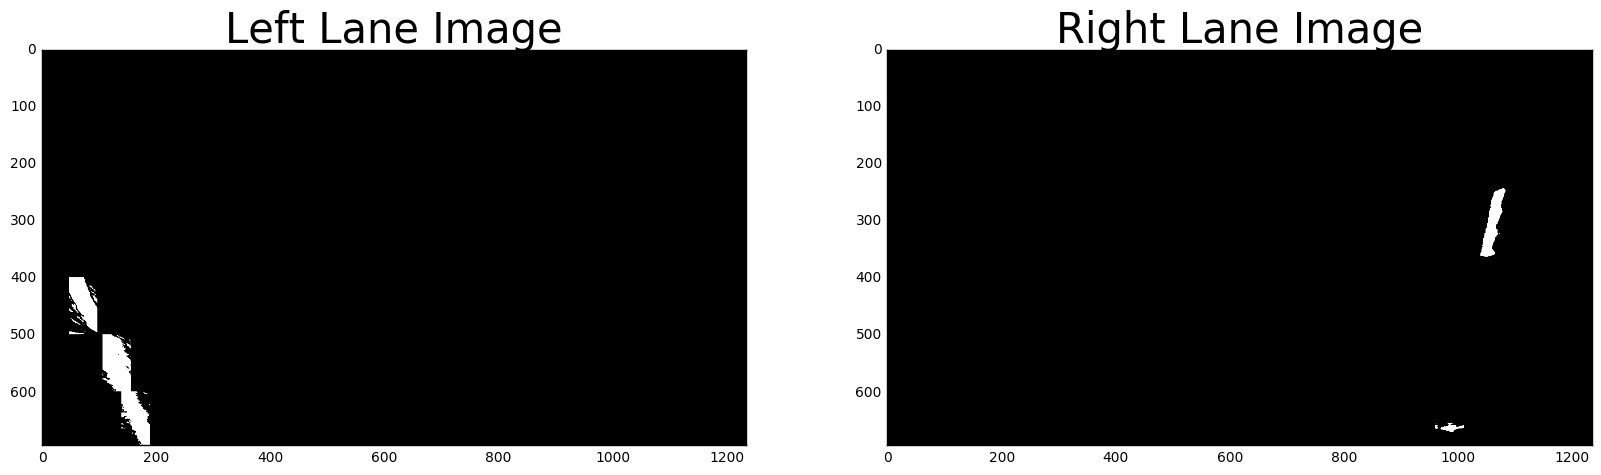

In [35]:
def find_lane_points_bak(binary_image, show_image=False):
    """
    """
    lane_width = 25
    lanes_dist = 700
    tolerance  = 150
    #lanes_dist = 780
    #tolerance  = 70

    margin = 100
    delta = 40
    l_margin = margin
    r_margin = margin
    
    mid = int(binary_img.shape[1]/2)
    width  = binary_image.shape[1]
    height = binary_image.shape[0]
    
    nb_win = 7
    win_size = math.ceil(height/nb_win)

    l_y_vals = []
    l_x_vals = []
    
    r_y_vals = []
    r_x_vals = []
    
    l_pnts = np.zeros_like(binary_image)
    r_pnts = np.zeros_like(binary_image)
    
    l_peak = None
    r_peak = None
    
    l_prev = None
    r_prev = None
    
    for i in range(nb_win):
        if show_image:
            print('Window ({})'.format(i))
        idx = (nb_win - 1) - i

        start = idx * win_size
        end = start + win_size

        histogram = np.sum(binary_image[start:end, :], axis=0)

        # first band
        if not l_prev or not r_prev:
            l_peak = np.argmax(histogram[:mid])
            r_peak = np.argmax(histogram[mid:]) + mid

        # rest of bands
        else:
            l_hist = histogram[l_prev-l_margin:l_prev+l_margin]
            r_hist = histogram[r_prev-r_margin:r_prev+r_margin]
                
            l_peak = np.argmax(l_hist) + l_prev-l_margin if len(l_hist) > 0 else None
            r_peak = np.argmax(r_hist) + r_prev-r_margin if len(r_hist) > 0 else None
            
        # Valid lane line found
        if (l_prev and r_prev) or abs((r_peak - l_peak) - lanes_dist) < tolerance:
            
            if l_peak:
                l_mask = binary_image[start:end, l_peak-lane_width:l_peak+lane_width] == 1
                if l_mask.sum() > 50:
                    l_pnts[start:end, l_peak-lane_width:l_peak+lane_width][l_mask] = 1
                    l_prev = l_peak
                    l_margin = margin
                else:
                    l_margin += delta
            else:
                l_margin += delta
                if show_image:
                    print('Left lane not found. margin: {}'.format(l_margin))
                
            if r_peak:
                r_mask = binary_image[start:end, r_peak-lane_width:r_peak+lane_width] == 1
                if r_mask.sum() > 50:
                    r_pnts[start:end, r_peak-lane_width:r_peak+lane_width][r_mask] = 1
                    r_prev = r_peak
                    r_margin = margin
                else:
                    r_margin += delta
            else:
                r_margin += delta
                if show_image:
                    print('Right lane not found. margin: {}'.format(r_margin))

    if show_image:        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(l_pnts, cmap='gray')
        ax1.set_title('Left Lane Image', fontsize=30)
        ax2.imshow(r_pnts, cmap='gray')
        ax2.set_title('Right Lane Image', fontsize=30)
        
    l_points = np.where(l_pnts == 1)
    r_points = np.where(r_pnts == 1)
    l_points = [l_points[1], l_points[0]]
    r_points = [r_points[1], r_points[0]]
    return l_points, r_points, l_pnts, r_pnts

l_points, r_points, _, _ = find_lane_points_bak(binary_img1, show_image=True)

In [8]:
def find_lane_points(binary_image):
    """
    """
    out_img = np.dstack((binary_image, binary_image, binary_image))*255
    out_img = out_img.astype(np.uint8)

    green = (0, 255, 0)
    
    margin = 100
    minpix = 50
    
    l_margin = margin
    r_margin = margin
    
    mid = binary_img.shape[1] // 2
    histogram = np.sum(binary_image[mid:,:], axis=0)
    l_base = np.argmax(histogram[:mid])
    r_base = np.argmax(histogram[mid:]) + mid
            
    width  = binary_image.shape[1]
    height = binary_image.shape[0]
    
    nb_win = 8
    win_size = math.ceil(height/nb_win)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    l_inds = []
    r_inds = []
    
    l_curr = l_base
    r_curr = r_base
    
    for i in range(nb_win):
        idx = (nb_win - 1) - i

        h_min =   idx * win_size
        h_max = h_min + win_size
        
        l_min = l_curr - margin
        l_max = l_curr + margin
        r_min = r_curr - margin
        r_max = r_curr + margin
        
        cv2.rectangle(out_img, (l_min, h_min), (l_max, h_max), green, 2)
        cv2.rectangle(out_img, (r_min, h_min), (r_max, h_max), green ,2)

        l_fits = (
            (nonzeroy >= h_min) & 
            (nonzeroy <  h_max) & 
            (nonzerox >= l_min) & 
            (nonzerox <  l_max)).nonzero()[0]
        
        r_fits = (
            (nonzeroy >= h_min) & 
            (nonzeroy <  h_max) & 
            (nonzerox >= r_min) & 
            (nonzerox <  r_max)).nonzero()[0]
        
        l_inds.extend(l_fits)
        r_inds.extend(r_fits)
        
        if len(l_fits) > minpix:
            l_curr = np.int(np.mean(nonzerox[l_fits]))
        if len(r_fits) > minpix:
            r_curr = np.int(np.mean(nonzerox[r_fits]))
            
    lx = nonzerox[l_inds]
    ly = nonzeroy[l_inds]
    rx = nonzerox[r_inds]
    ry = nonzeroy[r_inds]
    
    out_img[nonzeroy[l_inds], nonzerox[l_inds]] = [255, 0, 0]
    out_img[nonzeroy[r_inds], nonzerox[r_inds]] = [0, 0, 255]

    return [lx, ly], [rx, ry], out_img

l_points, r_points, out_img = find_lane_points(binary_img)

In [9]:
def find_lane_points_with_prev(l_fit, r_fit, binary_image):

    margin = 100
    
    nonzero = binary_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    l_inds = (
        (nonzerox > (l_fit[0]*(nonzeroy**2) + l_fit[1]*nonzeroy + l_fit[2] - margin)) & 
        (nonzerox < (l_fit[0]*(nonzeroy**2) + l_fit[1]*nonzeroy + l_fit[2] + margin))) 
    r_inds = (
        (nonzerox > (r_fit[0]*(nonzeroy**2) + r_fit[1]*nonzeroy + r_fit[2] - margin)) & 
        (nonzerox < (r_fit[0]*(nonzeroy**2) + r_fit[1]*nonzeroy + r_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    lx = nonzerox[l_inds]
    ly = nonzeroy[l_inds] 
    rx = nonzerox[r_inds]
    ry = nonzeroy[r_inds]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_image, binary_image, binary_image))*255
    window_img = np.zeros_like(out_img)
    
    # Color in left and right line pixels
    out_img[nonzeroy[l_inds], nonzerox[l_inds]] = [255, 0, 0]
    out_img[nonzeroy[r_inds], nonzerox[r_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    y_vals = np.linspace(0, binary_image.shape[0]-1, binary_image.shape[0])
    l_x_fit = l_fit[0]*y_vals**2 + l_fit[1]*y_vals + l_fit[2]
    r_x_fit = r_fit[0]*y_vals**2 + r_fit[1]*y_vals + r_fit[2]
    
    l_window1 = np.array([np.transpose(np.vstack([l_x_fit-margin, y_vals]))])
    l_window2 = np.array([np.flipud(np.transpose(np.vstack([l_x_fit+margin, y_vals])))])
    l_pts = np.hstack((l_window1, l_window2))
    
    r_window1 = np.array([np.transpose(np.vstack([r_x_fit-margin, y_vals]))])
    r_window2 = np.array([np.flipud(np.transpose(np.vstack([r_x_fit+margin, y_vals])))])
    r_pts = np.hstack((r_window1, r_window2))
    
    cv2.fillPoly(window_img, np.int_([l_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([r_pts]), (0,255, 0))
    out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    return [lx, ly], [rx, ry], out_img


## 6. Measure Curvature

4927.88705429 1688.37560966


(720, 0)

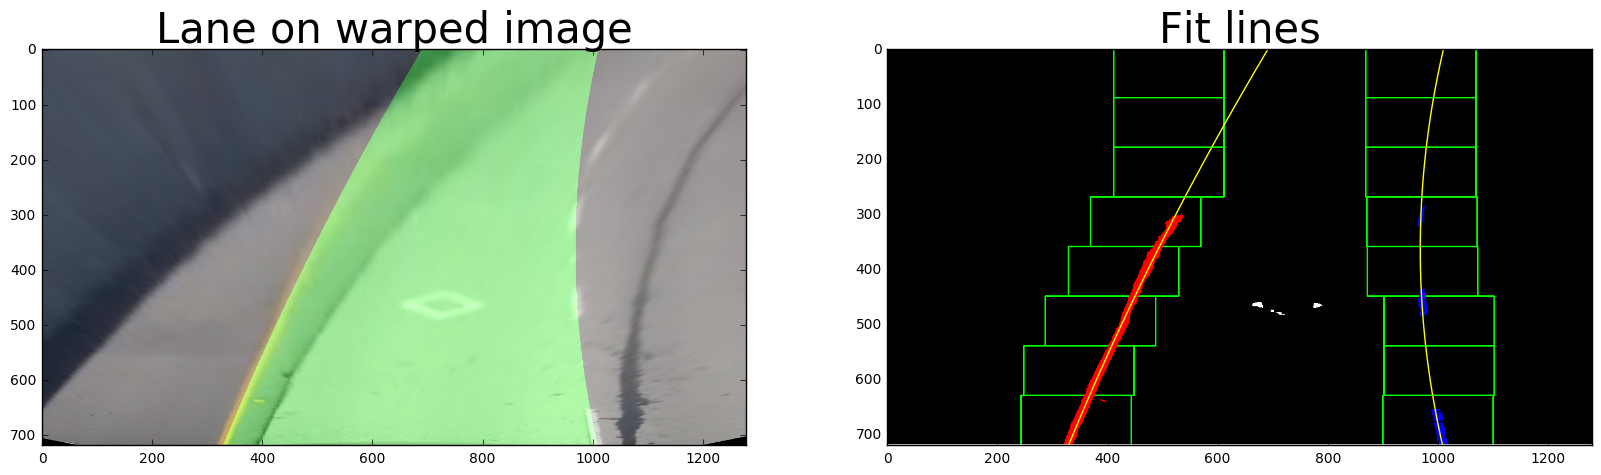

In [10]:
def fit_poly(x_vals, y_vals, y_max):
    # fit second order polynomial
    line_fit = np.polyfit(y_vals, x_vals, 2)
    
    # calculate radius of curvature
    curverad = ((1 + (2*line_fit[0]*y_max + line_fit[1])**2)**1.5) \
                             /np.absolute(2*line_fit[0])
    return line_fit, curverad

height = binary_img.shape[0]
l_fit, l_curverad = fit_poly(l_points[0], l_points[1], height)
r_fit, r_curverad = fit_poly(r_points[0], r_points[1], height)
print (l_curverad, r_curverad)

# Create an image to draw the lines on
color_warp = np.zeros_like(warped).astype(np.uint8)

# Recast the x and y points into usable format for cv2.fillPoly()
y_vals = np.linspace(0, binary_img.shape[0]-1, binary_img.shape[0])
l_x_fit = l_fit[0]*y_vals**2 + l_fit[1]*y_vals + l_fit[2]
r_x_fit = r_fit[0]*y_vals**2 + r_fit[1]*y_vals + r_fit[2]

pts_left  = np.array([np.transpose(np.vstack([l_x_fit, y_vals]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([r_x_fit, y_vals])))])
pts = np.hstack((pts_left, pts_right))

# visualize the results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
result = cv2.addWeighted(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB), 1, color_warp, 0.3, 0)
ax1.imshow(result)
ax1.set_title('Lane on warped image', fontsize=30)
# Draw found points
ax2.imshow(out_img)
ax2.plot(l_x_fit, y_vals, color='yellow')
ax2.plot(r_x_fit, y_vals, color='yellow')
ax2.set_title('Fit lines', fontsize=30)
ax2.set_xlim(0, 1280)
ax2.set_ylim(720, 0)


4927.88705429 1688.37560966


(720, 0)

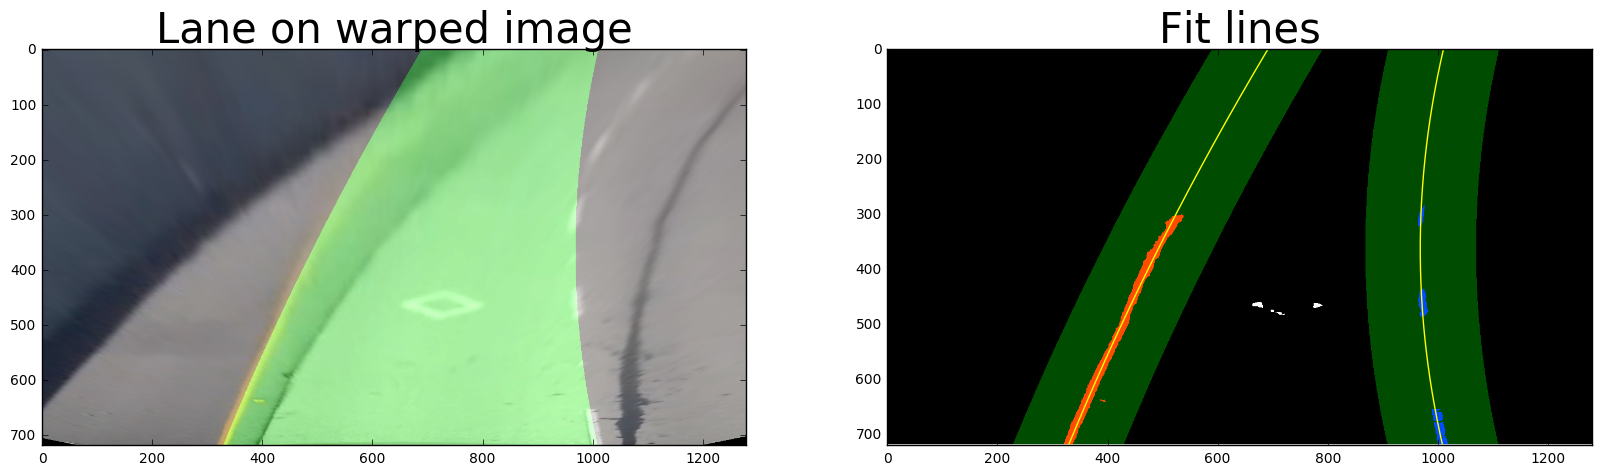

In [11]:
l_points, r_points, out_img = find_lane_points_with_prev(l_fit, r_fit, binary_img)


height = binary_img.shape[0]
l_fit, l_curverad = fit_poly(l_points[0], l_points[1], height)
r_fit, r_curverad = fit_poly(r_points[0], r_points[1], height)
print (l_curverad, r_curverad)

# Create an image to draw the lines on
color_warp = np.zeros_like(warped).astype(np.uint8)

# Recast the x and y points into usable format for cv2.fillPoly()
y_vals = np.linspace(0, binary_img.shape[0]-1, binary_img.shape[0])
l_x_fit = l_fit[0]*y_vals**2 + l_fit[1]*y_vals + l_fit[2]
r_x_fit = r_fit[0]*y_vals**2 + r_fit[1]*y_vals + r_fit[2]

pts_left  = np.array([np.transpose(np.vstack([l_x_fit, y_vals]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([r_x_fit, y_vals])))])
pts = np.hstack((pts_left, pts_right))

# visualize the results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
result = cv2.addWeighted(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB), 1, color_warp, 0.3, 0)
ax1.imshow(result)
ax1.set_title('Lane on warped image', fontsize=30)
# Draw found points
ax2.imshow(out_img)
ax2.plot(l_x_fit, y_vals, color='yellow')
ax2.plot(r_x_fit, y_vals, color='yellow')
ax2.set_title('Fit lines', fontsize=30)
ax2.set_xlim(0, 1280)
ax2.set_ylim(720, 0)

## 7 & 8. Reversed Perspective Transform

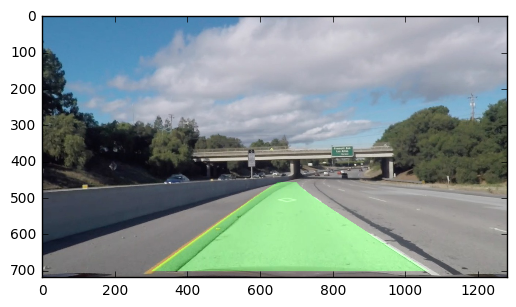

In [13]:
def create_lane_boundary_image(l_fit, r_fit, image):

    # Create an image to draw the lines on
    color_warp  = np.zeros_like(image).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    y_vals = np.linspace(0, 100, num=101)*(image.shape[1]/100)
    l_x_fit = l_fit[0]*y_vals**2 + l_fit[1]*y_vals + l_fit[2]
    r_x_fit = r_fit[0]*y_vals**2 + r_fit[1]*y_vals + r_fit[2]

    pts_left  = np.array([np.transpose(np.vstack([l_x_fit, y_vals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([r_x_fit, y_vals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    return color_warp

boundary = create_lane_boundary_image(l_fit, r_fit, dst)
boundary, M = perspective_transform(boundary, inverse=True)

result = cv2.addWeighted(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB), 1, boundary, 0.3, 0)
plt.imshow(result)


## Video

In [14]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Line class

Define a class to receive the characteristics of each line detection

In [64]:
class Line():
    def __init__(self):  
        #: meters per pixel in y dimension
        self.ym_per_pix = 3/115 
        #: meters per pixel in x dimension
        self.xm_per_pix = 3.7/750 
        
        self.radius_of_curvature = None
        self.fit = None
        self.detected = False
        
    @property
    def min_diff(self):
        return ()
    
    def fit_poly(self, x_vals, y_vals, y_max):
        
        if not x_vals.any() or not y_vals.any():
            return 
        
        # fit second order polynomial
        self.fit = np.polyfit(y_vals, x_vals, 2)

        # calculate radius of curvature
        fit_m = np.polyfit(y_vals*self.ym_per_pix,
                           x_vals*self.xm_per_pix, 2)
        self.radius_of_curvature = \
            ((1 + (2*fit_m[0]*y_max*self.ym_per_pix + fit_m[1])**2)**1.5) / \
            np.absolute(2*fit_m[0])

class Lane():
    
    def __init__(self, prev_lane=None):
        #: meters per pixel in y dimension
        self.ym_per_pix = 3./100 
        #: meters per pixel in x dimension
        self.xm_per_pix = 3.7/740 

        self.center = 0
        self.detected = False
        self.left_line = Line()
        self.right_line = Line()
        
        self.prev_lane = prev_lane
    
    def validate(self, prev_lane):
        
        result = True
        result = result and self.validate_lines()
        if prev_lane:
            result = result and self.validate_line_diff(prev_lane.left_line, self.left_line)
            result = result and self.validate_line_diff(prev_lane.right_line, self.right_line)
        self.detected = result 
    
    def validate_lines(self):
        
        if self.left_line and self.left_line.fit is not None and \
            self.right_line and self.right_line.fit is not None:
            # check distance between left lane and right lane
            self.center = ((self.left_line.fit[2] + self.right_line.fit[2]) / 2 - 640) \
                          * self.xm_per_pix
            self.distance = np.abs(self.left_line.fit[2] - self.right_line.fit[2]) \
                            * self.xm_per_pix
            
            print('Center: {}'.format(self.center))
            print('Distance: {}'.format(self.distance))
            return True
            # check curvature difference between left lane and right lane
            
        return False
    
    def validate_line_diff(self, prev, curr):
        
        print("Prev: {}".format(prev.fit))
        print("Curr: {}".format(curr.fit))
        if 
        print("Diff: {}".format(curr.fit - prev.fit))
        return True
        
        
    def create_lane_boundary_image(self, image):
        l_fit = self.left_line.fit 
        r_fit = self.right_line.fit
        
        # Create an image to draw the lines on
        color_warp  = np.zeros_like(image).astype(np.uint8)

        # Recast the x and y points into usable format for cv2.fillPoly()
        y_vals = np.linspace(0, 100, num=101)*(image.shape[1]/100)
        l_x_fit = l_fit[0]*y_vals**2 + l_fit[1]*y_vals + l_fit[2]
        r_x_fit = r_fit[0]*y_vals**2 + r_fit[1]*y_vals + r_fit[2]

        pts_left  = np.array([np.transpose(np.vstack([l_x_fit, y_vals]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([r_x_fit, y_vals])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
        return color_warp        
    

In [57]:
MTX, DIST = load_undistort_params()

def process_frame(image):
    
    image = image.copy()
    
    # lane detection pipeline
    undist    = undistort_image(image, MTX, DIST)
    warped, M = perspective_transform(undist)
    equalized = histogram_equalization(warped)
    binary    = create_threshold_binary_image(equalized)
    
    # load previous detected lane line
    prev_lane = process_frame.history[-1] if process_frame.history else None
    
    # extract lane lines
    if prev_lane and prev_lane.detected:
        print("######### with prev")
        l_points, r_points, out_img = find_lane_points_with_prev(
            prev_lane.left_line.fit, prev_lane.right_line.fit, binary)
    else:
        print("######### without prev")
        l_points, r_points, out_img = find_lane_points(binary)
        
    # default value
    boundary = np.zeros_like(undist)
    result = undist
    
    curr_lane = Lane()
    curr_lane.left_line.fit_poly(l_points[0], l_points[1], height)
    curr_lane.right_line.fit_poly(r_points[0], r_points[1], height)
    curr_lane.validate(prev_lane)

    if curr_lane.detected:
        boundary = curr_lane.create_lane_boundary_image(undist)
        boundary, M = perspective_transform(boundary, inverse=True)
        result = cv2.addWeighted(undist, 1, boundary, 0.3, 0)
        
    if len(process_frame.history) >= 3:
        process_frame.history.pop(0)
    process_frame.history.append(curr_lane)
  
    
    # build the result frame
    new_h = image.shape[0]//2
    new_w = image.shape[1]//2
    output = np.zeros_like(image)
    
    undist = cv2.resize(undist, (0, 0), fx=.5, fy=.5)
    binary = cv2.resize(binary, (0, 0), fx=.5, fy=.5)
    out_img = cv2.resize(out_img, (0, 0), fx=.5, fy=.5)

    binary[binary > 0] = 255
    
    boundary = cv2.resize(boundary, (0, 0), fx=.5, fy=.5)
    result = cv2.resize(result, (0, 0), fx=.5, fy=.5)
    output[:new_h,:new_w] = undist
    output[new_h:, :new_w] = out_img
    output[:new_h, new_w:] = boundary
    output[new_h:, new_w:] = result
    
    # Print text
    cv2.putText(output, "Left curvature: %.1f m." % curr_lane.left_line.radius_of_curvature, 
                (50, 70), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)
    
    return output 

In [125]:
MTX, DIST = load_undistort_params()

def process_image(image):

    p_l_fit = process_image.p_l_fit
    p_r_fit = process_image.p_r_fit
    
    image = image.copy()
    
    undist = undistort_image(image, MTX, DIST)
    warped, M = perspective_transform(undist)
    equalized = histogram_equalization(warped)
    binary = create_threshold_binary_image(equalized)
    
    if p_l_fit is None or p_r_fit is None:
        l_points, r_points, out_img = find_lane_points(binary)
    else:
        l_points, r_points, out_img = find_lane_points_with_prev(p_l_fit, p_r_fit, binary)
    
    boundary = np.zeros_like(undist)
    
    if len(l_points[0]) > 0 and len(l_points[1]) > 0 and len(r_points[0]) > 0 and len(r_points[1]) > 0:
        l_fit, l_curverad = fit_poly(l_points[0], l_points[1], height)
        r_fit, r_curverad = fit_poly(r_points[0], r_points[1], height)

        boundary = create_lane_boundary_image(l_fit, r_fit, undist)
        boundary, M = perspective_transform(boundary, inverse=True)
        result = cv2.addWeighted(undist, 1, boundary, 0.3, 0)
        
        process_image.p_l_fit = l_fit
        process_image.p_r_fit = r_fit
    else:
        result = undist

    # build the result frame
    new_h = image.shape[0]//2
    new_w = image.shape[1]//2
    output = np.zeros_like(image)
    
    undist = cv2.resize(undist, (0, 0), fx=.5, fy=.5)
    binary = cv2.resize(binary, (0, 0), fx=.5, fy=.5)
    out_img = cv2.resize(out_img, (0, 0), fx=.5, fy=.5)

    binary[binary > 0] = 255
    
    boundary = cv2.resize(boundary, (0, 0), fx=.5, fy=.5)
    result = cv2.resize(result, (0, 0), fx=.5, fy=.5)
    output[:new_h,:new_w] = undist
    output[new_h:, :new_w] = out_img
    output[:new_h, new_w:] = boundary
    output[new_h:, new_w:] = result
    return output 

#: a function attribute to keep previously detected line objects
process_image.history = []

In [67]:
process_frame.history = []

output = 'videos/project_video_output.mp4'
clip_in = VideoFileClip("videos/project_video.mp4").subclip(0,2)
clip_out = clip_in.fl_image(process_frame)
%time clip_out.write_videofile(output, audio=False)

######### without prev
[MoviePy] >>>> Building video videos/project_video_output.mp4
[MoviePy] Writing video videos/project_video_output.mp4




  0%|          | 0/51 [00:00<?, ?it/s]

######### without prev




  2%|▏         | 1/51 [00:00<00:08,  5.61it/s]

######### without prev
Center: -0.41061294041989355
Distance: 3.6340966604843126
Prev: [ -3.13025416e-04   4.12007216e-01   1.96943789e+02]
Curr: [ -3.26117355e-04   4.26584326e-01   1.94467746e+02]
Diff: [ -1.30919389e-05   1.45771096e-02  -2.47604263e+00]
Prev: None
Curr: [ -2.92306808e-04   4.51540454e-01   9.21287078e+02]


TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

In [193]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [65]:
process_frame.history = []

output = 'videos/challenge_video_output.mp4'
clip_in = VideoFileClip("videos/challenge_video.mp4").subclip(0, 2)
clip_out = clip_in.fl_image(process_frame)
%time clip_out.write_videofile(output, audio=False)

######### without prev
Center: 1.137808472743178
Distance: 2.0038401235268766
[MoviePy] >>>> Building video videos/challenge_video_output.mp4
[MoviePy] Writing video videos/challenge_video_output.mp4




  0%|          | 0/60 [00:00<?, ?it/s]

######### with prev
Center: 1.1378084727431672
Distance: 2.0038401235268917
Prev: [ -4.88884545e-05  -4.26502484e-01   6.67177682e+02]
Curr: [ -4.88884545e-05  -4.26502484e-01   6.67177682e+02]
Diff: [ -1.25835215e-17   1.18793864e-14  -3.75166564e-12]
Prev: [  3.27251264e-04  -2.60776014e-01   1.06794571e+03]
Curr: [  3.27251264e-04  -2.60776014e-01   1.06794571e+03]
Diff: [  4.30970364e-17  -2.44249065e-14  -6.82121026e-13]




  2%|▏         | 1/60 [00:00<00:11,  4.95it/s]

######### with prev
Center: 1.3283531646744888



  3%|▎         | 2/60 [00:00<00:11,  4.96it/s]


Distance: 1.56863729079833
Prev: [ -4.88884545e-05  -4.26502484e-01   6.67177682e+02]
Curr: [  1.94137430e-04  -7.11355845e-01   7.48806904e+02]
Diff: [  2.43025884e-04  -2.84853361e-01   8.16292217e+01]
Prev: [  3.27251264e-04  -2.60776014e-01   1.06794571e+03]
Curr: [  3.22603052e-04  -2.52081331e-01   1.06253436e+03]
Diff: [ -4.64821152e-06   8.69468298e-03  -5.41134489e+00]
######### with prev
Center: 1.5243889291319028
Distance: 1.099693100022995
Prev: [  1.94137430e-04  -7.11355845e-01   7.48806904e+02]
Curr: [  4.17278913e-04  -9.89598758e-01   8.34908476e+02]
Diff: [  2.23141484e-04  -2.78242913e-01   8.61015720e+01]
Prev: [  3.22603052e-04  -2.52081331e-01   1.06253436e+03]
Curr: [  3.00207975e-04  -2.29382441e-01   1.05484710e+03]
Diff: [ -2.23950766e-05   2.26988902e-02  -7.68726619e+00]




  5%|▌         | 3/60 [00:00<00:11,  5.07it/s]

######### with prev
Center: 1.5358129591718717
Distance: 1.0765676620168614
Prev: [  4.17278913e-04  -9.89598758e-01   8.34908476e+02]
Curr: [  4.36540265e-04  -1.01070042e+00   8.39505826e+02]
Diff: [  1.92613513e-05  -2.11016590e-02   4.59734981e+00]
Prev: [  3.00207975e-04  -2.29382441e-01   1.05484710e+03]




  7%|▋         | 4/60 [00:00<00:11,  5.07it/s]

Curr: [  2.92182067e-04  -2.23868826e-01   1.05481936e+03]
Diff: [ -8.02590832e-06   5.51361544e-03  -2.77377926e-02]
######### with prev




  8%|▊         | 5/60 [00:00<00:10,  5.14it/s]

Center: 1.4483266376352288
Distance: 1.1889266613238811
Prev: [  4.36540265e-04  -1.01070042e+00   8.39505826e+02]
Curr: [  3.58026749e-04  -9.12145486e-01   8.10772661e+02]
Diff: [ -7.85135155e-05   9.85549313e-02  -2.87331642e+01]
Prev: [  2.92182067e-04  -2.23868826e-01   1.05481936e+03]
Curr: [  2.84248403e-04  -2.12174748e-01   1.04855799e+03]
Diff: [ -7.93366391e-06   1.16940779e-02  -6.26136438e+00]
######### with prev
Center: 1.3255084138764313
Distance: 1.4423418207459515
Prev: [  3.58026749e-04  -9.12145486e-01   8.10772661e+02]
Curr: [  2.18912755e-04  -7.44270263e-01   7.60867501e+02]
Diff: [ -1.39113994e-04   1.67875223e-01  -4.99051607e+01]
Prev: [  2.84248403e-04  -2.12174748e-01   1.04855799e+03]
Curr: [  2.95972583e-04  -2.21916206e-01   1.04933586e+03]
Diff: [  1.17241800e-05  -9.74145873e-03   7.77871190e-01]




 10%|█         | 6/60 [00:01<00:10,  5.16it/s]

######### with prev
Center: 1.2955255693637884
Distance: 1.4906923836773138
Prev: [  2.18912755e-04  -7.44270263e-01   7.60867501e+02]
Curr: [  1.60370941e-04  -6.88108845e-01   7.50035876e+02]
Diff: [ -5.85418137e-05   5.61614178e-02  -1.08316252e+01]
Prev: [  2.95972583e-04  -2.21916206e-01   1.04933586e+03]
Curr: [  3.49607216e-04  -2.48393658e-01   1.04817435e+03]
Diff: [  5.36346330e-05  -2.64774516e-02  -1.16151261e+00]




 12%|█▏        | 7/60 [00:01<00:10,  5.18it/s]

 13%|█▎        | 8/60 [00:01<00:10,  5.05it/s]

######### with prev
Center: 1.284825158837037
Distance: 1.5266612180816048
Prev: [  1.60370941e-04  -6.88108845e-01   7.50035876e+02]
Curr: [  1.23451881e-04  -6.55235653e-01   7.44298910e+02]
Diff: [ -3.69190600e-05   3.28731923e-02  -5.73696555e+00]
Prev: [  3.49607216e-04  -2.48393658e-01   1.04817435e+03]
Curr: [  3.44583704e-04  -2.50194086e-01   1.04963115e+03]
Diff: [ -5.02351228e-06  -1.80042821e-03   1.45680134e+00]
######### with prev



 15%|█▌        | 9/60 [00:01<00:10,  5.10it/s]


Center: 1.2195171558733255
Distance: 1.6036504445830486
Prev: [  1.23451881e-04  -6.55235653e-01   7.44298910e+02]
Curr: [  6.85454043e-05  -5.85369469e-01   7.23538387e+02]
Diff: [ -5.49064768e-05   6.98661841e-02  -2.07605232e+01]
Prev: [  3.44583704e-04  -2.50194086e-01   1.04963115e+03]
Curr: [  3.30194554e-04  -2.33811010e-01   1.04426848e+03]
Diff: [ -1.43891496e-05   1.63830756e-02  -5.36267794e+00]
######### with prev
Center: 1.2098585230780816
Distance: 1.6847448342330285
Prev: [  6.85454043e-05  -5.85369469e-01   7.23538387e+02]
Curr: [  3.79287236e-05  -5.48080390e-01   7.13497221e+02]
Diff: [ -3.06166807e-05   3.72890783e-02  -1.00411655e+01]
Prev: [  3.30194554e-04  -2.33811010e-01   1.04426848e+03]
Curr: [  3.80303544e-04  -2.72730483e-01   1.05044619e+03]
Diff: [  5.01089900e-05  -3.89194721e-02   6.17771241e+00]




 17%|█▋        | 10/60 [00:01<00:09,  5.12it/s]

 18%|█▊        | 11/60 [00:02<00:09,  5.17it/s]

######### with prev
Center: 1.0371801886967114
Distance: 1.9967244226703473
Prev: [  3.79287236e-05  -5.48080390e-01   7.13497221e+02]
Curr: [ -1.15270724e-04  -3.48664657e-01   6.47763595e+02]
Diff: [ -1.53199448e-04   1.99415733e-01  -6.57336257e+01]
Prev: [  3.80303544e-04  -2.72730483e-01   1.05044619e+03]
Curr: [  3.26593124e-04  -2.34632091e-01   1.04710848e+03]
Diff: [ -5.37104204e-05   3.80983913e-02  -3.33770803e+00]
######### with prev




 20%|██        | 12/60 [00:02<00:09,  5.15it/s]

Center: 1.1271307763163998
Distance: 1.7967807662223225
Prev: [ -1.15270724e-04  -3.48664657e-01   6.47763595e+02]
Curr: [  7.09924106e-06  -4.89723866e-01   6.85748079e+02]
Diff: [  1.22369965e-04  -1.41059209e-01   3.79844832e+01]
Prev: [  3.26593124e-04  -2.34632091e-01   1.04710848e+03]
Curr: [  2.89811146e-04  -2.08649054e-01   1.04510423e+03]
Diff: [ -3.67819777e-05   2.59830370e-02  -2.00424812e+00]
######### with prev
Center: 1.1387246378009672
Distance: 1.7428807315583499
Prev: [  7.09924106e-06  -4.89723866e-01   6.85748079e+02]
Curr: [  4.05885697e-05  -5.25859486e-01   6.93456854e+02]
Diff: [  3.34893286e-05  -3.61356200e-02   7.70877576e+00]
Prev: [  2.89811146e-04  -2.08649054e-01   1.04510423e+03]
Curr: [  2.57811054e-04  -1.84967345e-01   1.04203300e+03]
Diff: [ -3.20000925e-05   2.36817097e-02  -3.07123117e+00]




 22%|██▏       | 13/60 [00:02<00:09,  5.21it/s]

 23%|██▎       | 14/60 [00:02<00:08,  5.17it/s]

######### with prev
Center: 1.116751691854866
Distance: 1.8272325673700278
Prev: [  4.05885697e-05  -5.25859486e-01   6.93456854e+02]
Curr: [  2.65409380e-05  -4.97003415e-01   6.80627082e+02]
Diff: [ -1.40476317e-05   2.88560712e-02  -1.28297728e+01]
Prev: [  2.57811054e-04  -1.84967345e-01   1.04203300e+03]
Curr: [  2.50185662e-04  -1.88308552e-01   1.04607360e+03]
Diff: [ -7.62539161e-06  -3.34120703e-03   4.04059439e+00]
######### with prev




 25%|██▌       | 15/60 [00:02<00:08,  5.23it/s]

Center: 1.042240854630328
Distance: 2.0151001994221445
Prev: [  2.65409380e-05  -4.97003415e-01   6.80627082e+02]
Curr: [ -6.01055083e-05  -3.89261750e-01   6.46938151e+02]
Diff: [ -8.66464463e-05   1.07741665e-01  -3.36889307e+01]
Prev: [  2.50185662e-04  -1.88308552e-01   1.04607360e+03]
Curr: [  2.95044548e-04  -2.20471672e-01   1.04995819e+03]
Diff: [  4.48588857e-05  -3.21631206e-02   3.88459576e+00]
######### with prev
Center: 1.0552036813966992
Distance: 1.9316356107076604
Prev: [ -6.01055083e-05  -3.89261750e-01   6.46938151e+02]
Curr: [ -1.94329322e-05  -4.35518822e-01   6.57877175e+02]
Diff: [  4.06725761e-05  -4.62570726e-02   1.09390242e+01]
Prev: [  2.95044548e-04  -2.20471672e-01   1.04995819e+03]
Curr: [  2.86289135e-04  -2.07427109e-01   1.04420430e+03]
Diff: [ -8.75541303e-06   1.30445636e-02  -5.75389352e+00]




 27%|██▋       | 16/60 [00:03<00:08,  5.22it/s]

 28%|██▊       | 17/60 [00:03<00:08,  5.24it/s]

######### with prev
Center: 1.102062751153021
Distance: 1.833682083216748
Prev: [ -1.94329322e-05  -4.35518822e-01   6.57877175e+02]
Curr: [  5.28049128e-05  -5.13942052e-01   6.77044342e+02]
Diff: [  7.22378449e-05  -7.84232295e-02   1.91671667e+01]
Prev: [  2.86289135e-04  -2.07427109e-01   1.04420430e+03]
Curr: [  2.80945885e-04  -2.04284902e-01   1.04378076e+03]
Diff: [ -5.34325014e-06   3.14220676e-03  -4.23538798e-01]
######### with prev




 30%|███       | 18/60 [00:03<00:08,  5.16it/s]

Center: 1.0605746500699678
Distance: 1.8174480373733934
Prev: [  5.28049128e-05  -5.13942052e-01   6.77044342e+02]
Curr: [  3.84213147e-05  -4.92915902e-01   6.70370126e+02]
Diff: [ -1.43835981e-05   2.10261495e-02  -6.67421563e+00]
Prev: [  2.80945885e-04  -2.04284902e-01   1.04378076e+03]
Curr: [  2.86813007e-04  -1.98789065e-01   1.03385973e+03]
Diff: [  5.86712209e-06   5.49583729e-03  -9.92102480e+00]
######### with prev
Center: 1.132104632101797
Distance: 1.6728398221147525
Prev: [  3.84213147e-05  -4.92915902e-01   6.70370126e+02]
Curr: [  1.33960553e-04  -6.03142477e-01   6.99136944e+02]
Diff: [  9.55392380e-05  -1.10226575e-01   2.87668179e+01]
Prev: [  2.86813007e-04  -1.98789065e-01   1.03385973e+03]
Curr: [  2.69482515e-04  -1.89175777e-01   1.03370491e+03]
Diff: [ -1.73304916e-05   9.61328785e-03  -1.54825119e-01]




 32%|███▏      | 19/60 [00:03<00:07,  5.21it/s]

 33%|███▎      | 20/60 [00:03<00:07,  5.01it/s]

######### with prev
Center: 1.1482961727250092
Distance: 1.5941101007800296
Prev: [  1.33960553e-04  -6.03142477e-01   6.99136944e+02]
Curr: [  1.81014687e-04  -6.50554463e-01   7.10248224e+02]
Diff: [  4.70541340e-05  -4.74119859e-02   1.11112803e+01]
Prev: [  2.69482515e-04  -1.89175777e-01   1.03370491e+03]
Curr: [  2.83230199e-04  -1.92763220e-01   1.02907024e+03]
Diff: [  1.37476836e-05  -3.58744321e-03  -4.63466401e+00]
######### with prev




 35%|███▌      | 21/60 [00:04<00:07,  5.09it/s]

Center: 1.1693753394906845
Distance: 1.5788803283429087
Prev: [  1.81014687e-04  -6.50554463e-01   7.10248224e+02]
Curr: [  2.09449935e-04  -6.80257297e-01   7.15987035e+02]
Diff: [  2.84352486e-05  -2.97028342e-02   5.73881060e+00]
Prev: [  2.83230199e-04  -1.92763220e-01   1.02907024e+03]
Curr: [  2.91538232e-04  -2.03001800e-01   1.03176310e+03]
Diff: [  8.30803319e-06  -1.02385798e-02   2.69285611e+00]
######### with prev
Center: 1.1793580450822732
Distance: 1.5849534591303183
Prev: [  2.09449935e-04  -6.80257297e-01   7.15987035e+02]
Curr: [  2.10410170e-04  -6.81739416e-01   7.17376263e+02]
Diff: [  9.60234401e-07  -1.48211943e-03   1.38922804e+00]
Prev: [  2.91538232e-04  -2.03001800e-01   1.03176310e+03]




 37%|███▋      | 22/60 [00:04<00:07,  5.07it/s]

 38%|███▊      | 23/60 [00:04<00:07,  5.12it/s]

Curr: [  3.59577301e-04  -2.51243648e-01   1.03436695e+03]
Diff: [  6.80390687e-05  -4.82418484e-02   2.60385420e+00]
######### with prev
Center: 1.1315830946646008
Distance: 1.6440863189966621
Prev: [  2.10410170e-04  -6.81739416e-01   7.17376263e+02]
Curr: [  1.91496492e-04  -6.49609698e-01   7.01907987e+02]
Diff: [ -1.89136777e-05   3.21297186e-02  -1.54682761e+01]
Prev: [  3.59577301e-04  -2.51243648e-01   1.03436695e+03]
Curr: [  2.99104564e-04  -2.08631140e-01   1.03072525e+03]
Diff: [ -6.04727368e-05   4.26125078e-02  -3.64170410e+00]
######### with prev




 40%|████      | 24/60 [00:04<00:07,  5.12it/s]

Center: 1.176255111681578
Distance: 1.4985715359517275
Prev: [  1.91496492e-04  -6.49609698e-01   7.01907987e+02]
Curr: [  2.44221373e-04  -7.18527584e-01   7.25393869e+02]
Diff: [  5.27248810e-05  -6.89178860e-02   2.34858817e+01]
Prev: [  2.99104564e-04  -2.08631140e-01   1.03072525e+03]
Curr: [  3.13370331e-04  -2.14279917e-01   1.02510818e+03]
Diff: [  1.42657670e-05  -5.64877691e-03  -5.61707490e+00]
######### with prev
Center: 1.1515492087130679



 42%|████▏     | 25/60 [00:04<00:06,  5.06it/s]


Distance: 1.5331473396664996
Prev: [  2.44221373e-04  -7.18527584e-01   7.25393869e+02]
Curr: [  2.04200099e-04  -6.79317334e-01   7.16995108e+02]
Diff: [ -4.00212745e-05   3.92102500e-02  -8.39876097e+00]
Prev: [  3.13370331e-04  -2.14279917e-01   1.02510818e+03]
Curr: [  3.21765481e-04  -2.22391245e-01   1.02362458e+03]
Diff: [  8.39514991e-06  -8.11132749e-03  -1.48360022e+00]
######### with prev
Center: 1.0867587828221092




 43%|████▎     | 26/60 [00:05<00:06,  5.02it/s]

Distance: 1.553400429986972
Prev: [  2.04200099e-04  -6.79317334e-01   7.16995108e+02]
Curr: [  1.16848473e-04  -5.95522852e-01   7.02011714e+02]
Diff: [ -8.73516259e-05   8.37944824e-02  -1.49833942e+01]
Prev: [  3.21765481e-04  -2.22391245e-01   1.02362458e+03]
Curr: [  3.27355111e-04  -2.17779046e-01   1.01269180e+03]
Diff: [  5.58962986e-06   4.61219843e-03  -1.09327761e+01]
######### with prev
Center: 1.101007129440312



 45%|████▌     | 27/60 [00:05<00:06,  4.99it/s]


Distance: 1.5611201921285494
Prev: [  1.16848473e-04  -5.95522852e-01   7.02011714e+02]
Curr: [  1.26522439e-04  -6.07932183e-01   7.04089407e+02]
Diff: [  9.67396604e-06  -1.24093315e-02   2.07769311e+00]
Prev: [  3.27355111e-04  -2.17779046e-01   1.01269180e+03]
Curr: [  3.37049369e-04  -2.30953537e-01   1.01631345e+03]
Diff: [  9.69425878e-06  -1.31744912e-02   3.62164554e+00]
######### with prev
Center: 1.1059067595156904
Distance: 1.5674743749009121




 47%|████▋     | 28/60 [00:05<00:06,  4.97it/s]

Prev: [  1.26522439e-04  -6.07932183e-01   7.04089407e+02]
Curr: [  1.09364597e-04  -5.94595142e-01   7.04433914e+02]
Diff: [ -1.71578413e-05   1.33370405e-02   3.44507738e-01]
Prev: [  3.37049369e-04  -2.30953537e-01   1.01631345e+03]
Curr: [  3.82543723e-04  -2.68808234e-01   1.01792879e+03]
Diff: [  4.54943537e-05  -3.78546964e-02   1.61534429e+00]
######### with prev
Center: 1.0483248878451537
Distance: 1.6248238902632375
Prev: [  1.09364597e-04  -5.94595142e-01   7.04433914e+02]
Curr: [  5.55567436e-05  -5.34196917e-01   6.87182589e+02]
Diff: [ -5.38078538e-05   6.03982253e-02  -1.72513259e+01]
Prev: [  3.82543723e-04  -2.68808234e-01   1.01792879e+03]
Curr: [  3.59652660e-04  -2.48858360e-01   1.01214737e+03]
Diff: [ -2.28910633e-05   1.99498739e-02  -5.78142280e+00]




 48%|████▊     | 29/60 [00:05<00:06,  5.01it/s]

 50%|█████     | 30/60 [00:05<00:05,  5.04it/s]

######### with prev
Center: 1.016280113589001
Distance: 1.6346253948793652
Prev: [  5.55567436e-05  -5.34196917e-01   6.87182589e+02]
Curr: [  5.88397403e-05  -5.26355124e-01   6.79793483e+02]
Diff: [  3.28299674e-06   7.84179276e-03  -7.38910531e+00]
Prev: [  3.59652660e-04  -2.48858360e-01   1.01214737e+03]
Curr: [  3.23839595e-04  -2.22402721e-01   1.00671856e+03]
Diff: [ -3.58130649e-05   2.64556389e-02  -5.42880439e+00]
######### with prev




 52%|█████▏    | 31/60 [00:06<00:05,  5.07it/s]

Center: 0.974822017310654
Distance: 2.0346106060073272
Prev: [  5.88397403e-05  -5.26355124e-01   6.79793483e+02]
Curr: [ -6.94260040e-05  -3.66971273e-01   6.31503343e+02]
Diff: [ -1.28265744e-04   1.59383851e-01  -4.82901404e+01]
Prev: [  3.23839595e-04  -2.22402721e-01   1.00671856e+03]
Curr: [  4.29984921e-04  -3.44473357e-01   1.03842546e+03]
Diff: [  1.06145326e-04  -1.22070636e-01   3.17069019e+01]
######### with prev
Center: 0.9399851304361897
Distance: 2.0524635595890426
Prev: [ -6.94260040e-05  -3.66971273e-01   6.31503343e+02]
Curr: [ -6.46197790e-05  -3.55810487e-01   6.22750670e+02]
Diff: [  4.80622495e-06   1.11607857e-02  -8.75267273e+00]
Prev: [  4.29984921e-04  -3.44473357e-01   1.03842546e+03]
Curr: [  3.99999356e-04  -3.20068450e-01   1.03324338e+03]
Diff: [ -2.99855655e-05   2.44049067e-02  -5.18208202e+00]




 53%|█████▎    | 32/60 [00:06<00:05,  5.08it/s]

 55%|█████▌    | 33/60 [00:06<00:05,  5.11it/s]

######### with prev
Center: 0.8980743949660098
Distance: 2.180560013183401
Prev: [ -6.46197790e-05  -3.55810487e-01   6.22750670e+02]
Curr: [ -9.85123073e-05  -3.02135173e-01   6.01558878e+02]
Diff: [ -3.38925283e-05   5.36753145e-02  -2.11917925e+01]
Prev: [  3.99999356e-04  -3.20068450e-01   1.03324338e+03]
Curr: [  4.06184199e-04  -3.33622871e-01   1.03767088e+03]
Diff: [  6.18484298e-06  -1.35544212e-02   4.42749827e+00]
######### with prev




 57%|█████▋    | 34/60 [00:06<00:05,  5.09it/s]

Center: 0.8410941202093437
Distance: 2.1363453181074195
Prev: [ -9.85123073e-05  -3.02135173e-01   6.01558878e+02]
Curr: [ -9.42961894e-05  -2.95346070e-01   5.94584292e+02]
Diff: [  4.21611797e-06   6.78910284e-03  -6.97458544e+00]
Prev: [  4.06184199e-04  -3.33622871e-01   1.03767088e+03]
Curr: [  3.42825654e-04  -2.72708417e-01   1.02185336e+03]
Diff: [ -6.33585446e-05   6.09144542e-02  -1.58175245e+01]
######### with prev
Center: 0.9195896543773818
Distance: 2.213937406057988
Prev: [ -9.42961894e-05  -2.95346070e-01   5.94584292e+02]
Curr: [ -4.21415232e-05  -3.42489040e-01   6.02524190e+02]
Diff: [  5.21546661e-05  -4.71429698e-02   7.93989804e+00]
Prev: [  3.42825654e-04  -2.72708417e-01   1.02185336e+03]
Curr: [  4.21344606e-04  -3.60699683e-01   1.04531167e+03]
Diff: [  7.85189517e-05  -8.79912658e-02   2.34583156e+01]




 58%|█████▊    | 35/60 [00:06<00:04,  5.11it/s]

 60%|██████    | 36/60 [00:07<00:04,  5.11it/s]

######### with prev
Center: 0.9432228389171724
Distance: 2.256185167644656
Prev: [ -4.21415232e-05  -3.42489040e-01   6.02524190e+02]
Curr: [ -6.49281100e-05  -3.28572955e-01   6.03026051e+02]
Diff: [ -2.27865868e-05   1.39160847e-02   5.01860749e-01]
Prev: [  4.21344606e-04  -3.60699683e-01   1.04531167e+03]
Curr: [  5.03388366e-04  -4.31405682e-01   1.05426308e+03]
Diff: [  8.20437608e-05  -7.07059995e-02   8.95141307e+00]
######### with prev




 62%|██████▏   | 37/60 [00:07<00:04,  5.10it/s]

Center: 0.8950787408877909
Distance: 2.487956500440141
Prev: [ -6.49281100e-05  -3.28572955e-01   6.03026051e+02]
Curr: [ -1.64500591e-04  -2.12960741e-01   5.70220098e+02]
Diff: [ -9.95724808e-05   1.15612214e-01  -3.28059529e+01]
Prev: [  5.03388366e-04  -4.31405682e-01   1.05426308e+03]
Curr: [  5.91576923e-04  -5.10064127e-01   1.06781140e+03]
Diff: [  8.81885564e-05  -7.86584449e-02   1.35483137e+01]
######### with prev




 63%|██████▎   | 38/60 [00:07<00:04,  5.03it/s]

Center: 1.2042034550759684
Distance: 2.404066943492609
Prev: [ -1.64500591e-04  -2.12960741e-01   5.70220098e+02]
Curr: [  2.75781715e-05  -4.46356405e-01   6.40433997e+02]
Diff: [  1.92078762e-04  -2.33395663e-01   7.02138985e+01]
Prev: [  5.91576923e-04  -5.10064127e-01   1.06781140e+03]
Curr: [  9.16121581e-04  -7.90462139e-01   1.12124739e+03]
Diff: [  3.24544658e-04  -2.80398012e-01   5.34359871e+01]
######### with prev
Center: 1.1313979197964779
Distance: 2.221676117061412
Prev: [  2.75781715e-05  -4.46356405e-01   6.40433997e+02]
Curr: [  5.90877672e-05  -4.75809920e-01   6.44111972e+02]
Diff: [  3.15095957e-05  -2.94535154e-02   3.67797559e+00]
Prev: [  9.16121581e-04  -7.90462139e-01   1.12124739e+03]
Curr: [  6.87193149e-04  -6.09761579e-01   1.08844720e+03]
Diff: [ -2.28928432e-04   1.80700559e-01  -3.28001897e+01]




 65%|██████▌   | 39/60 [00:07<00:04,  5.10it/s]

 67%|██████▋   | 40/60 [00:07<00:03,  5.15it/s]

######### with prev
Center: 1.2819435992644241
Distance: 2.127660209717626
Prev: [  5.90877672e-05  -4.75809920e-01   6.44111972e+02]
Curr: [  1.86733367e-04  -6.22227007e-01   6.83622699e+02]
Diff: [  1.27645599e-04  -1.46417087e-01   3.95107266e+01]
Prev: [  6.87193149e-04  -6.09761579e-01   1.08844720e+03]
Curr: [  7.51178423e-04  -6.86599529e-01   1.10915474e+03]
Diff: [  6.39852747e-05  -7.68379494e-02   2.07075452e+01]
######### with prev




 68%|██████▊   | 41/60 [00:08<00:03,  5.14it/s]

Center: 1.4253065419845121
Distance: 2.137301142879228
Prev: [  1.86733367e-04  -6.22227007e-01   6.83622699e+02]
Curr: [  3.11937697e-04  -7.51523531e-01   7.11331194e+02]
Diff: [  1.25204330e-04  -1.29296524e-01   2.77084952e+01]
Prev: [  7.51178423e-04  -6.86599529e-01   1.10915474e+03]
Curr: [  8.69966152e-04  -8.04451954e-01   1.13879142e+03]
Diff: [  1.18787729e-04  -1.17852425e-01   2.96366819e+01]
######### with prev




 70%|███████   | 42/60 [00:08<00:03,  5.02it/s]

Center: 1.389229068979123
Distance: 2.294901290984021
Prev: [  3.11937697e-04  -7.51523531e-01   7.11331194e+02]
Curr: [  2.60221568e-04  -6.84252232e-01   6.88355685e+02]
Diff: [ -5.17161285e-05   6.72712985e-02  -2.29755094e+01]
Prev: [  8.69966152e-04  -8.04451954e-01   1.13879142e+03]
Curr: [  8.74910054e-04  -8.27968122e-01   1.14733594e+03]
Diff: [  4.94390170e-06  -2.35161681e-02   8.54452021e+00]
######### with prev
Center: 1.260132570425044
Distance: 2.5552364122614466
Prev: [  2.60221568e-04  -6.84252232e-01   6.88355685e+02]
Curr: [  8.64718650e-05  -4.91522362e-01   6.36502873e+02]



 72%|███████▏  | 43/60 [00:08<00:03,  5.02it/s]


Diff: [ -1.73749703e-04   1.92729870e-01  -5.18528118e+01]
Prev: [  8.74910054e-04  -8.27968122e-01   1.14733594e+03]
Curr: [  8.57101604e-04  -8.25519179e-01   1.14755016e+03]
Diff: [ -1.78084500e-05   2.44894332e-03   2.14212417e-01]
######### with prev
Center: 1.357952024230088
Distance: 2.419778138065202
Prev: [  8.64718650e-05  -4.91522362e-01   6.36502873e+02]
Curr: [  1.63698672e-04  -5.95715908e-01   6.69612591e+02]
Diff: [  7.72268074e-05  -1.04193545e-01   3.31097182e+01]
Prev: [  8.57101604e-04  -8.25519179e-01   1.14755016e+03]
Curr: [  8.53898961e-04  -8.41146635e-01   1.15356822e+03]
Diff: [ -3.20264295e-06  -1.56274567e-02   6.01806334e+00]




 73%|███████▎  | 44/60 [00:08<00:03,  5.06it/s]

 75%|███████▌  | 45/60 [00:08<00:02,  5.10it/s]

######### with prev
Center: 1.5041505335695684
Distance: 2.1797072974301495
Prev: [  1.63698672e-04  -5.95715908e-01   6.69612591e+02]
Curr: [  2.81478712e-04  -7.53892655e-01   7.22859377e+02]
Diff: [  1.17780039e-04  -1.58176748e-01   5.32467859e+01]
Prev: [  8.53898961e-04  -8.41146635e-01   1.15356822e+03]
Curr: [  8.57619000e-04  -8.61621570e-01   1.15880084e+03]
Diff: [  3.72003973e-06  -2.04749343e-02   5.23261780e+00]
######### with prev




 77%|███████▋  | 46/60 [00:09<00:02,  5.12it/s]

Center: 1.4323738112558204
Distance: 2.2411621106738613
Prev: [  2.81478712e-04  -7.53892655e-01   7.22859377e+02]
Curr: [  2.33909171e-04  -6.98332420e-01   7.02358551e+02]
Diff: [ -4.75695408e-05   5.55602353e-02  -2.05008258e+01]
Prev: [  8.57619000e-04  -8.61621570e-01   1.15880084e+03]
Curr: [  7.83926427e-04  -8.02869571e-01   1.15059097e+03]
Diff: [ -7.36925735e-05   5.87519986e-02  -8.20986314e+00]
######### with prev
Center: 1.6603196693055873
Distance: 2.0548566461432256
Prev: [  2.33909171e-04  -6.98332420e-01   7.02358551e+02]
Curr: [  4.17194934e-04  -9.19786163e-01   7.66578269e+02]
Diff: [  1.83285763e-04  -2.21453742e-01   6.42197181e+01]
Prev: [  7.83926427e-04  -8.02869571e-01   1.15059097e+03]
Curr: [  8.42964244e-04  -8.86857120e-01   1.17754960e+03]
Diff: [  5.90378170e-05  -8.39875491e-02   2.69586252e+01]




 78%|███████▊  | 47/60 [00:09<00:02,  5.12it/s]

 80%|████████  | 48/60 [00:09<00:02,  5.15it/s]

######### with prev
Center: 1.7388788714399914
Distance: 1.9489242669718367
Prev: [  4.17194934e-04  -9.19786163e-01   7.66578269e+02]
Curr: [  5.06738153e-04  -1.02045774e+00   7.92883348e+02]
Diff: [  8.95432187e-05  -1.00671574e-01   2.63050783e+01]
Prev: [  8.42964244e-04  -8.86857120e-01   1.17754960e+03]
Curr: [  8.40400107e-04  -8.95658268e-01   1.18266820e+03]
Diff: [ -2.56413656e-06  -8.80114831e-03   5.11860251e+00]
######### with prev




 82%|████████▏ | 49/60 [00:09<00:02,  5.18it/s]

Center: 1.9377555644642643
Distance: 1.6856084462059926
Prev: [  5.06738153e-04  -1.02045774e+00   7.92883348e+02]
Curr: [  6.45994389e-04  -1.21327415e+00   8.58990268e+02]
Diff: [  1.39256237e-04  -1.92816413e-01   6.61069207e+01]
Prev: [  8.40400107e-04  -8.95658268e-01   1.18266820e+03]
Curr: [  8.81969391e-04  -9.47795832e-01   1.19611196e+03]
Diff: [  4.15692838e-05  -5.21375633e-02   1.34437565e+01]
######### with prev
Center: 1.92571881180094
Distance: 1.9310896017897967
Prev: [  6.45994389e-04  -1.21327415e+00   8.58990268e+02]
Curr: [  5.21548377e-04  -1.09425039e+00   8.32034802e+02]
Diff: [ -1.24446013e-04   1.19023764e-01  -2.69554661e+01]
Prev: [  8.81969391e-04  -9.47795832e-01   1.19611196e+03]
Curr: [  1.02303079e-03  -1.06581994e+00   1.21825272e+03]
Diff: [  1.41061399e-04  -1.18024109e-01   2.21407650e+01]




 83%|████████▎ | 50/60 [00:09<00:01,  5.11it/s]

 85%|████████▌ | 51/60 [00:09<00:01,  5.11it/s]

######### with prev
Center: 1.9259854636888962
Distance: 2.019689409689755
Prev: [  5.21548377e-04  -1.09425039e+00   8.32034802e+02]
Curr: [  4.82505667e-04  -1.05470817e+00   8.23228152e+02]
Diff: [ -3.90427094e-05   3.95422165e-02  -8.80665041e+00]
Prev: [  1.02303079e-03  -1.06581994e+00   1.21825272e+03]
Curr: [  1.01804561e-03  -1.08421198e+00   1.22716603e+03]
Diff: [ -4.98517692e-06  -1.83920426e-02   8.91331117e+00]
######### with prev




 87%|████████▋ | 52/60 [00:10<00:01,  5.15it/s]

Center: 1.7659877346692623
Distance: 2.350272069304844
Prev: [  4.82505667e-04  -1.05470817e+00   8.23228152e+02]
Curr: [  2.89291061e-04  -8.29433200e-01   7.58170340e+02]
Diff: [ -1.93214606e-04   2.25274969e-01  -6.50578118e+01]
Prev: [  1.01804561e-03  -1.08421198e+00   1.22716603e+03]
Curr: [  9.89351634e-04  -1.07276002e+00   1.22822475e+03]
Diff: [ -2.86939786e-05   1.14519595e-02   1.05872016e+00]
######### with prev
Center: 1.9010715162607823
Distance: 2.144564346134544
Prev: [  2.89291061e-04  -8.29433200e-01   7.58170340e+02]
Curr: [  3.79155416e-04  -9.61056805e-01   8.05757869e+02]
Diff: [  8.98643551e-05  -1.31623605e-01   4.75875286e+01]
Prev: [  9.89351634e-04  -1.07276002e+00   1.22822475e+03]
Curr: [  9.76104138e-04  -1.07936725e+00   1.23467074e+03]
Diff: [ -1.32474966e-05  -6.60722854e-03   6.44598400e+00]




 88%|████████▊ | 53/60 [00:10<00:01,  5.16it/s]

 90%|█████████ | 54/60 [00:10<00:01,  5.17it/s]

######### with prev
Center: 1.8110813175627458
Distance: 2.345351150457562
Prev: [  3.79155416e-04  -9.61056805e-01   8.05757869e+02]
Curr: [  3.24653549e-04  -8.73413825e-01   7.67681148e+02]
Diff: [ -5.45018669e-05   8.76429800e-02  -3.80767202e+01]
Prev: [  9.76104138e-04  -1.07936725e+00   1.23467074e+03]
Curr: [  9.50315905e-04  -1.06252567e+00   1.23675138e+03]
Diff: [ -2.57882325e-05   1.68415869e-02   2.08064069e+00]
######### with prev




 92%|█████████▏| 55/60 [00:10<00:00,  5.20it/s]

Center: 2.0276608516628847
Distance: 2.1225572635952537
Prev: [  3.24653549e-04  -8.73413825e-01   7.67681148e+02]
Curr: [  4.83812463e-04  -1.07808336e+00   8.33276444e+02]
Diff: [  1.59158913e-04  -2.04669532e-01   6.55952955e+01]
Prev: [  9.50315905e-04  -1.06252567e+00   1.23675138e+03]
Curr: [  1.00660590e-03  -1.13330894e+00   1.25778790e+03]
Diff: [  5.62899988e-05  -7.07832793e-02   2.10365181e+01]
######### with prev
Center: 2.108115878731969
Distance: 1.9760530868447597
Prev: [  4.83812463e-04  -1.07808336e+00   8.33276444e+02]
Curr: [  5.43490838e-04  -1.16497327e+00   8.64017867e+02]
Diff: [  5.96783755e-05  -8.68899089e-02   3.07414231e+01]
Prev: [  1.00660590e-03  -1.13330894e+00   1.25778790e+03]
Curr: [  9.68599064e-04  -1.11591210e+00   1.25922848e+03]
Diff: [ -3.80068400e-05   1.73968426e-02   1.44058774e+00]




 93%|█████████▎| 56/60 [00:10<00:00,  5.17it/s]

 95%|█████████▌| 57/60 [00:11<00:00,  5.22it/s]

######### with prev
Center: 1.8653680298229716
Distance: 2.3498921625702827
Prev: [  5.43490838e-04  -1.16497327e+00   8.64017867e+02]
Curr: [  3.04672264e-04  -8.76299651e-01   7.78084390e+02]
Diff: [ -2.38818575e-04   2.88673614e-01  -8.59334774e+01]
Prev: [  9.68599064e-04  -1.11591210e+00   1.25922848e+03]
Curr: [  8.84456630e-04  -1.04990798e+00   1.24806282e+03]
Diff: [ -8.41424341e-05   6.60041201e-02  -1.11656622e+01]
######### with prev




 97%|█████████▋| 58/60 [00:11<00:00,  5.15it/s]

Center: 1.9639999365693996
Distance: 2.3600951366598224
Prev: [  3.04672264e-04  -8.76299651e-01   7.78084390e+02]
Curr: [  3.26326450e-04  -9.18133516e-01   7.96790474e+02]
Diff: [  2.16541865e-05  -4.18338645e-02   1.87060839e+01]
Prev: [  8.84456630e-04  -1.04990798e+00   1.24806282e+03]
Curr: [  9.35094170e-04  -1.11854156e+00   1.26880950e+03]
Diff: [  5.06375397e-05  -6.86335772e-02   2.07466788e+01]
######### with prev




 98%|█████████▊| 59/60 [00:11<00:00,  5.12it/s]

Center: 2.000690735023776
Distance: 2.2497834183224312
Prev: [  3.26326450e-04  -9.18133516e-01   7.96790474e+02]
Curr: [  3.56601575e-04  -9.63423581e-01   8.15159805e+02]
Diff: [  3.02751250e-05  -4.52900653e-02   1.83693315e+01]
Prev: [  9.35094170e-04  -1.11854156e+00   1.26880950e+03]
Curr: [  8.91837001e-04  -1.08803115e+00   1.26511649e+03]
Diff: [ -4.32571689e-05   3.05104081e-02  -3.69301214e+00]
######### with prev
Center: 2.2630432925579704
Distance: 1.9973270970438837
Prev: [  3.56601575e-04  -9.63423581e-01   8.15159805e+02]
Curr: [  5.70465008e-04  -1.22646619e+00   8.92875949e+02]
Diff: [  2.13863433e-04  -2.63042607e-01   7.77161436e+01]
Prev: [  8.91837001e-04  -1.08803115e+00   1.26511649e+03]
Curr: [  9.51147300e-04  -1.16978519e+00   1.29234137e+03]
Diff: [  5.93102994e-05  -8.17540360e-02   2.72248794e+01]




100%|██████████| 60/60 [00:11<00:00,  5.09it/s]



[MoviePy] Done.
[MoviePy] >>>> Video ready: videos/challenge_video_output.mp4 

CPU times: user 15.4 s, sys: 4.18 s, total: 19.6 s
Wall time: 12.2 s


In [109]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [130]:
process_frame.history = []

output = 'videos/harder_challenge_video_output.mp4'
clip_in = VideoFileClip("videos/harder_challenge_video.mp4")#.subclip(0,10)
clip_out = clip_in.fl_image(process_image)
%time clip_out.write_videofile(output, audio=False)

[MoviePy] >>>> Building video videos/harder_challenge_video_output.mp4
[MoviePy] Writing video videos/harder_challenge_video_output.mp4



100%|█████████▉| 1199/1200 [04:06<00:00,  5.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos/harder_challenge_video_output.mp4 

CPU times: user 5min 18s, sys: 1min 26s, total: 6min 44s
Wall time: 4min 7s


In [83]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))